# Import library

In [1]:
import os
import math
import gc
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
# os.environ["KERAS_BACKEND"] = "tensorflow"

# import keras_cv
# import keras_core as keras
# from keras_core import layers

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import torchvision
from torchvision import transforms

from pathlib import Path
import numpy as np
import pandas as pd
#import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from tqdm.notebook import tqdm
from glob import glob
from joblib import Parallel, delayed
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Prepare to train

## Dataset

## Create png from dicom

Convert dicom to png

In [ ]:
def standardize_pixel_array(dcm):
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)
    return pixel_array

def read_xray(path, fix_monochrome=True):
    dicom = pydicom.dcmread(path)
    data = standardize_pixel_array(dicom)
    data = data - np.min(data)
    data = data / (np.max(data) + 1e-5)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    return data

def resize_and_save(df, idx):
    path = df['image_path'][idx].split('/')
    set_type = path[4]
    patient_id = path[5]
    series_id = path[6]

    kidney = 0
    liver = 0
    spleen = 0
    
    if set_type == 'train_images':
        DF = patient_df[patient_df['patient_id'] == int(patient_id)]
        #For kidney
        if DF['kidney_low'].values[0] == 1:
            kidney = 1
        elif DF['kidney_high'].values[0] == 1:
            kidney = 2

        #For liver
        if DF['liver_low'].values[0] == 1:
            liver = 1
        elif DF['liver_high'].values[0] == 1:
            liver = 2

        #For spleen
        if DF['spleen_low'].values[0] == 1:
            spleen = 1
        elif DF['spleen_high'].values[0] == 1:
            spleen = 2

        save_folder = f'{BASE_PATH}/{set_type}/{patient_id}_{kidney}_{liver}_{spleen}/{series_id}'
    else:
        save_folder = f'{BASE_PATH}/{set_type}/{patient_id}/{series_id}'
    os.makedirs(save_folder, exist_ok = True)
#     print(df.instance_number[idx])
#     print(save_folder)
    if os.path.exists(f'{save_folder}/{df.instance_number[idx]}.png'):
        return
    img = read_xray(df.dicom_path[idx])
    #h, w = img.shape[:2]  # orig hw
    img = cv2.resize(img, config.IMAGE_SIZE, cv2.INTER_LINEAR)
    img = (img * 255).astype(np.uint8)
    cv2.imwrite(f'{save_folder}/{df.instance_number[idx]}.png', img)
    return

In [ ]:
p1 = Parallel(n_jobs=2, backend="threading")(
    delayed(resize_and_save)(test_df, test_idx) for test_idx in tqdm(range(len(test_df)), leave=True, position=0)
    
)
#!zip -m test.zip /kaggle/working/Group_Project/test_images
p2 = Parallel(n_jobs=2, backend="threading")(
    delayed(resize_and_save)(train_df, train_idx) for train_idx in tqdm(range(len(train_df)), leave=True, position=0)
)
#!zip -m train_up.zip /kaggle/working/Group_Project/train_images

del p1, p2
gc.collect()


# Prepare dataset (╬▔皿▔)╯

In [ ]:
paths=[]
ids=[]
for dirname, _, filenames in os.walk('/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations'):
    for filename in filenames:
        ids+=[filename[0:-4]]
        paths+=[(os.path.join(dirname, filename))]

In [ ]:
def get_bound(image, colors):
    list_col = []
    benchmark_colors=[1, 2, 3, 4]   
#   organs=['liver','spleen', 'left kidney','right kidney']
    for color in colors:
        if color in benchmark_colors:
            x_list = [i[1] for i in np.argwhere(image==color)]
            y_list = [i[0] for i in np.argwhere(image==color)]
            xmin = min(x_list)
            xmax = max(x_list)
            ymin = min(y_list)
            ymax = max(y_list)
            xcenter = (xmin + xmax)/2
            xcenter = xcenter/image.shape[1]
            ycenter = (ymin + ymax)/2
            ycenter = ycenter/image.shape[0]
            width = ymax - ymin
            width = width/image.shape[1]
            height = xmax - xmin
            height = height/image.shape[0]
            label_org = benchmark_colors.index(color)
            list_col.append((label_org, xcenter, ycenter, width, height))
#         list_col.append((xmin, xmax, ymin, ymax))
    return list_col

In [ ]:
os.makedirs('/kaggle/working/train', exist_ok = True)
os.makedirs('/kaggle/working/test', exist_ok = True)

In [ ]:
# use number in segmentation to find imgs in dicom
dicom_path = list((src/ 'train_images').glob(f'*/10494'))[0]
patient_id, series_id = dicom_path.parent.name, dicom_path.name
print('patient_id is ' + patient_id, 'series_id is ' +series_id + ' in Segmentation folder')

imgs = []
files = sorted(
    list((src / 'train_images' / patient_id / series_id).glob('*.dcm')),
    key = lambda x : int(x.stem)
)
for f in files:
    imgs.append(pydicom.dcmread(f).pixel_array)
imgs = np.stack(imgs)

masks = niba.load('/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations/10494.nii').get_fdata()
masks = masks.transpose((2, 1, 0))[::-1, ::-1, :] # we change the order of the dimensions. Flip horizontally and vertically.

xarr_imgs = xr.DataArray(
    imgs,
    dims = ['file', 'height', 'width'],
    coords = [
        [f.name for f in files],
        [i for i in range(512)],
        [i for i in range(512)],
    ]
)

xarr_masks = xr.DataArray(
    masks,
    dims = ['file', 'height', 'width'],
    coords = [
        [f.name for f in files],
        [i for i in range(512)],
        [i for i in range(512)],
    ]
)

for j in tqdm(range(xarr_masks.shape[0])):
    # Read segment
    seg_img = (xarr_masks.isel(file = j).values).astype(np.uint8)
    colors_exist = np.unique(seg_img)

    if len(colors_exist)>2: # If more than 1 organ, >2 because we ignore bowel
        bboxes = get_bound(seg_img, colors_exist)
        fig, ax = plt.subplots(1, 2, figsize = (12, 6))
        ax[0].imshow(seg_img)
        ax[1].imshow(xarr_imgs.isel(file=j).values, cmap = 'gray')
        plt.axis('off')
        for bbox in bboxes:
            xcenter = bbox[1]*img.shape[1]
            ycenter = bbox[2]*img.shape[0]
            width = bbox[3]*img.shape[1]
            height = bbox[4]*img.shape[0]
        
            # Calculate the top-left and bottom-right coordinates of the bounding box
            x1 = int(xcenter - width / 2)
            y1 = int(ycenter - height / 2)
            x2 = int(xcenter + width / 2)
            y2 = int(ycenter + height / 2)

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        plt.show()


In [ ]:
src = Path('/kaggle/input/rsna-2023-abdominal-trauma-detection')
colors=[1, 2, 4, 3]
organs=['liver','spleen','right kidney','left kidney']
for i in tqdm(range(len(ids))):
    # use number in segmentation to find imgs in dicom
    dicom_path = list((src/ 'train_images').glob(f'*/{ids[i]}'))[0]
    patient_id, series_id = dicom_path.parent.name, dicom_path.name
    print('patient_id is ' + patient_id, 'series_id is ' +series_id + ' in Segmentation folder')
    
    imgs = []
    files = sorted(
        list((src / 'train_images' / patient_id / series_id).glob('*.dcm')),
        key = lambda x : int(x.stem)
    )
    for f in files:
        imgs.append(pydicom.dcmread(f).pixel_array)
    imgs = np.stack(imgs)
    
    masks = niba.load(paths[i]).get_fdata()
    masks = masks.transpose((2, 1, 0))[::-1, ::-1, :] # we change the order of the dimensions. Flip horizontally and vertically.
    
    xarr_imgs = xr.DataArray(
        imgs,
        dims = ['file', 'height', 'width'],
        coords = [
            [f.name for f in files],
            [i for i in range(512)],
            [i for i in range(512)],
        ]
    )

    xarr_masks = xr.DataArray(
        masks,
        dims = ['file', 'height', 'width'],
        coords = [
            [f.name for f in files],
            [i for i in range(512)],
            [i for i in range(512)],
        ]
    )
    
    for j in tqdm(range(xarr_masks.shape[0])):
        # Read segment
        seg_img = (xarr_masks.isel(file = j).values).astype(np.uint8)
        colors_exist = np.unique(seg_img)
                
        if len(colors_exist)>2 and 1 not in colors_exist: # If more than 1 organ
            fig, ax = plt.subplots(1, 2, figsize = (12, 6))
            ax[0].imshow(seg_img)
            ax[1].imshow(xarr_imgs.isel(file=j).values, cmap = 'gray')
            plt.axis('off')
            plt.show()
            print(colors_exist)
#             label_box = get_bound(seg_img, colors_exist)
#             print(label_box)
#             focus = xarr_imgs.isel(file=j).values
#             newfile= '/kaggle/working/sg/image/'+slice_id+'.jpg'
#             #cv2.imwrite(newfile,focus)
#             label_box = get_bound(hsv, color_exist)
#             with open(f'/kaggle/working/sg/label/{slice_id}.txt', 'w',encoding='UTF-8') as file:
#                 for box in label_box:
#                     file.write(f'{box[0]} {box[1]} {box[2]} {box[3]} {box[4]}\n')
            


In [ ]:
images=[]
colors=[(51, 51, 51), (255, 255, 255), (102, 102, 102), (204, 204, 204), (153, 153, 153)]
organs=['bowel','liver','spleen','right kidney','left kidney']
for path in paths:
    if path.split('/')[-1]=='51136.nii':
        nii_img = niba.load(path)
        data = nii_img.get_fdata()
        print(data.shape)
        imagesi=[]
        for i in range(data.shape[2]):
            
            #Read segment
            seg_img=(data[:,:,i]*51).astype(np.uint8)
            #image = cv2.imread(path0, cv2.IMREAD_COLOR)
            seg_image = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
            hsv = cv2.cvtColor(seg_image, cv2.COLOR_BGR2HSV)
            pixels = np.argwhere(hsv>0)
            all_colors = {tuple(image[pixel[0], pixel[1]]) for pixel in pixels}
            
            #if img.max()>0 and len(all_colors)>=4:
            fig, axs = plt.subplots(1, 2, figsize = (12, 6))
            #print(img.max())
            img=np.rot90(img)
            axs[0].imshow(img)
            axs[1].imshow(read_xray(test_path + '/' + str(i+sorted(test)[0])+'.dcm'), cmap = 'gray')
            plt.axis('off')
            plt.show()
            newfile='10494_seg_'+str(i).zfill(4)+'.png'
            print(test_path + '/' + str(i+sorted(test)[0])+'.dcm')
            print(newfile)
            #cv2.imwrite(newfile,img)
            imagesi+=[img]
        print(len(imagesi))
        images+=[imagesi]

# Training time ☆*: .｡. o(≧▽≦)o .｡.:*☆

## Training object detection

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()
from ultralytics import YOLO

In [ ]:
base_path = '/storage/student5/minh_chu/Abdominal'
plt.imshow(cv2.imread(f"{base_path}/data/images/20869_35067_43.jpg"))

In [37]:
df = pd.read_csv('/home/student5/minh_chu/train.csv')

In [44]:
df[df['patient_id'] == 10004]

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1


In [49]:
label = '10004_21057_401.txt'
with open(f'{label_path}/{label}', 'r') as file:
    datas = file.readlines()
    print(datas)
    new_datas = datas.copy()
    print(new_datas)
    for i in range(len(datas)):
        chosen_patient = df[df['patient_id'] == int(patient)]
        new_datas[i] = list(new_datas[i])
        if datas[i][0] == '0':
            print('h')
            if chosen_patient['liver_healthy'].iloc[0] == 1:
                new_datas[i][0] = '0'
            elif chosen_patient['liver_low'].iloc[0] == 1:
                new_datas[i][0] = '1'
            elif chosen_patient['liver_high'].iloc[0] == 1:
                new_datas[i][0] = '2'

        elif datas[i][0] == '1':
            print('h1')
            if chosen_patient['spleen_healthy'].iloc[0] == 1:
                new_datas[i][0] = '3'
            elif chosen_patient['spleen_low'].iloc[0] == 1:
                new_datas[i][0] = '4'
            elif chosen_patient['spleen_high'].iloc[0] == 1:
                new_datas[i][0] = '5'

        elif datas[i][0] == '2' or data[i][0] == '3':
            if chosen_patient['kidney_healthy'].iloc[0] == 1:
                new_datas[i][0] = '6'
            elif chosen_patient['kidney_low'].iloc[0] == 1:
                new_datas[i][0] = '7'
            elif chosen_patient['kidney_high'].iloc[0] == 1:
                new_datas[i][0] = '8'
        new_datas[i] = ''.join(new_datas[i])
    
    print(new_datas)


['0 0.447265625 0.4716796875 0.44921875 0.384765625\n', '1 0.6953125 0.5810546875 0.12109375 0.107421875\n']
['0 0.447265625 0.4716796875 0.44921875 0.384765625\n', '1 0.6953125 0.5810546875 0.12109375 0.107421875\n']
h
h1
['1 0.447265625 0.4716796875 0.44921875 0.384765625\n', '5 0.6953125 0.5810546875 0.12109375 0.107421875\n']


In [50]:
label_path = '/storage/student5/minh_chu/Abdominal/data/labels'

# liver_healthy, liver_low, liver_high
#      0              1          2

# spleen_healthy, spleen_low, spleen_high
#      3              4          5

# kidney_healthy, kidney_low, kidney_high
#      6              7          8
new_label_path = '/storage/student5/minh_chu/Abdominal/data/new_labels'
os.makedirs(new_label_path, exist_ok=True)
patient_list = set()
for label in tqdm(sorted(os.listdir(label_path))):
    patient = label.split('_')[0]
    patient_list.add(patient)
#     continue
    with open(f'{label_path}/{label}', 'r') as file:
        datas = file.readlines()
        new_datas = datas.copy()
        for i in range(len(datas)):
            chosen_patient = df[df['patient_id'] == int(patient)]
            new_datas[i] = list(new_datas[i])
            if datas[i][0] == '0':
                if chosen_patient['liver_healthy'].iloc[0] == 1:
                    new_datas[i][0] = '0'
                elif chosen_patient['liver_low'].iloc[0] == 1:
                    new_datas[i][0] = '1'
                elif chosen_patient['liver_high'].iloc[0] == 1:
                    new_datas[i][0] = '2'

            elif datas[i][0] == '1':
                if chosen_patient['spleen_healthy'].iloc[0] == 1:
                    new_datas[i][0] = '3'
                elif chosen_patient['spleen_low'].iloc[0] == 1:
                    new_datas[i][0] = '4'
                elif chosen_patient['spleen_high'].iloc[0] == 1:
                    new_datas[i][0] = '5'

            elif datas[i][0] == '2' or data[i][0] == '3':
                if chosen_patient['kidney_healthy'].iloc[0] == 1:
                    new_datas[i][0] = '6'
                elif chosen_patient['kidney_low'].iloc[0] == 1:
                    new_datas[i][0] = '7'
                elif chosen_patient['kidney_high'].iloc[0] == 1:
                    new_datas[i][0] = '8'
            new_datas[i] = ''.join(new_datas[i])
            
    with open(f'{new_label_path}/{label}', 'w') as new_label:
        for data in new_datas:
#             print(data)
            new_label.writelines(data)

            
        

  0%|          | 0/29148 [00:00<?, ?it/s]

In [53]:
import random
random.seed(42)
patient_list = list(patient_list)
random.shuffle(patient_list)

In [55]:
# Calculate the sizes of each split
total_size = len(patient_list)
train_size = int(0.7 * total_size)
valid_size = int(0.2 * total_size)
test_size = total_size - train_size - valid_size

# Split the list
train_data = patient_list[:train_size]
valid_data = patient_list[train_size:train_size+valid_size]
test_data = patient_list[train_size+valid_size:]

In [56]:
base_img_path = f'{base_path}/data/images'
segment_path = f'{base_path}/data/new_labels'

img_file = os.listdir(base_img_path)
segment_file = os.listdir(segment_path)

# Sort the list based on the numeric value
sorted_img = sorted(img_file, key=lambda x: x[:-4])
sorted_segment = sorted(segment_file, key=lambda x: x[:-4])

In [57]:
def move(x, y, img_path, label_path):
    old_x_path = base_img_path+'/'+x
    new_x_path = img_path+'/' + x
#         if os.path.exists(new_x_path):
#             continue
    shutil.copy(old_x_path, new_x_path)

    old_y_path = segment_path+'/'+y
    new_y_path = label_path+'/' + y
    shutil.copy(old_y_path, new_y_path)

In [58]:
for x, y in zip(tqdm(sorted_img), sorted_segment):
    if x.split('_')[0] in train_data:
        img_path = f'{base_path}/train/images'
        label_path = f'{base_path}/train/labels'
        os.makedirs(img_path,  exist_ok = True)
        os.makedirs(label_path,  exist_ok = True)
        move(x, y, img_path, label_path)
    elif x.split('_')[0] in valid_data:
        img_path = f'{base_path}/val/images'
        label_path = f'{base_path}/val/labels'
        os.makedirs(img_path,  exist_ok = True)
        os.makedirs(label_path,  exist_ok = True)
        move(x, y, img_path, label_path)
    elif x.split('_')[0] in test_data:
        img_path = f'{base_path}/test/images'
        label_path = f'{base_path}/test/labels'
        os.makedirs(img_path,  exist_ok = True)
        os.makedirs(label_path,  exist_ok = True)
        move(x, y, img_path, label_path)


  0%|          | 0/29148 [00:00<?, ?it/s]

In [41]:
# Splitting data
from sklearn.model_selection import train_test_split
import shutil

base_img_path = f'{base_path}/data/images'
segment_path = f'{base_path}/data/new_labels'

img_file = os.listdir(base_img_path)
segment_file = os.listdir(segment_path)

# Sort the list based on the numeric value
sorted_img = sorted(img_file, key=lambda x: x[:-4])
sorted_segment = sorted(segment_file, key=lambda x: x[:-4])

X_train, x_test, y_train, y_test = train_test_split(sorted_img, sorted_segment, test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/8, random_state=42)

def create_folder(X, Y, set_type):
    img_path = f'{base_path}/{set_type}/images'
    label_path = f'{base_path}/{set_type}/labels'
    os.makedirs(img_path,  exist_ok = True)
    os.makedirs(label_path,  exist_ok = True)
    for x, y in zip(tqdm(X), Y):
        old_x_path = base_img_path+'/'+x
        new_x_path = img_path+'/' + x
        if os.path.exists(new_x_path):
            continue
        shutil.copy(old_x_path, new_x_path)

        old_y_path = segment_path+'/'+y
        new_y_path = label_path+'/' + y
        shutil.copy(old_y_path, new_y_path)


create_folder(x_train, y_train, 'train')
create_folder(x_test, y_test, 'test')
create_folder(x_val, y_val, 'val')

  0%|          | 0/20403 [00:00<?, ?it/s]

  0%|          | 0/5830 [00:00<?, ?it/s]

  0%|          | 0/2915 [00:00<?, ?it/s]

In [33]:
with open(f'{base_path}/new_data.yaml', 'w') as data:
    data.write(
    """
    #Classes
    nc: 9 #num of classes
    names: ['liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high', 'kidney_healthy', 'kidney_low', 'kidney_high']
    
    path: /storage/student5/minh_chu/Abdominal
    test: test/images # test images
    train: train/images  # train images
    val: val/images # val images
    """)

In [59]:
#yolov8n(nano version for testing)
!yolo task=detect mode=train model=yolov8n.pt data='/storage/student5/minh_chu/Abdominal/new_data.yaml' epochs=50 device=1 batch=128

New https://pypi.org/project/ultralytics/8.1.6 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.230 🚀 Python-3.11.5 torch-2.1.2 CUDA:1 (NVIDIA GeForce RTX 3090, 24260MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/storage/student5/minh_chu/Abdominal/new_data.yaml, epochs=50, time=None, patience=50, batch=128, imgsz=640, save=True, save_period=-1, cache=False, device=1, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fals


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      17.2G      0.563      0.468      0.924        458        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       4956      11759      0.456      0.562      0.476      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      17.2G     0.5531     0.4463     0.9176        386        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       4956      11759      0.421      0.505      0.428      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      17.2G      0.543     0.4358     0.9156        440        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       4956      11759      0.399      0.501       0.41      0.346

      Epo


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50      17.2G     0.4282     0.2869     0.8713        450        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       4956      11759      0.462      0.507      0.484      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      17.2G     0.4252     0.2842      0.871        408        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       4956      11759      0.439       0.55      0.485      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50      17.3G     0.4193     0.2803     0.8689        431        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       4956      11759       0.43      0.524      0.451      0.394

      Epo

In [ ]:
with torch.cuda.device('cuda:1'):
    torch.cuda.empty_cache()

In [ ]:
import zipfile
import os

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in tqdm(files):
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Specify the folder path and the path for the resulting ZIP file
folder_path = '/storage/student5/minh_chu/Abdominal/train'
zip_path = '/home/student5/minh_chu/train.zip'

# Call the function
zip_folder(folder_path, zip_path)

In [62]:
!yolo task=detect mode=val model='/home/student5/minh_chu/runs/detect/train/weights/best.pt' data='/storage/student5/minh_chu/Abdominal/new_data.yaml' plots = True device=1 save = True

Ultralytics YOLOv8.0.230 🚀 Python-3.11.5 torch-2.1.2 CUDA:1 (NVIDIA GeForce RTX 3090, 24260MiB)
Model summary (fused): 168 layers, 3007403 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /storage/student5/minh_chu/Abdominal/val/labels.cache... 4956 imag
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       4956      11759      0.438       0.55      0.484      0.424
         liver_healthy       4956       1832      0.594      0.829      0.678      0.589
             liver_low       4956       2075      0.579      0.728      0.654      0.557
            liver_high       4956        509     0.0222    0.00786     0.0406     0.0339
        spleen_healthy       4956       2911      0.696      0.836      0.799      0.745
            spleen_low       4956        638      0.423      0.461      0.383      0.311
           spleen_high       4956       1274      0.547      0.603      0.554      0.394
        kidney_healthy       4956       

In [63]:
from IPython.display import display, Image

## Validation

In [ ]:
val_path = '/kaggle/working/runs/detect/val/'

In [ ]:
# Image(filename=val_path+'R_curve.png', width=600)
plt.imshow(cv2.imread(val_path+'R_curve.png'))
plt.axis('off')
plt.savefig('/kaggle/working/R_curve.png')

In [ ]:
plt.imshow(cv2.imread(val_path+'P_curve.png'))
plt.axis('off')
plt.savefig('/kaggle/working/P_curve.png')

In [ ]:
plt.imshow(cv2.imread(val_path+'PR_curve.png'))
plt.axis('off')
plt.savefig('/kaggle/working/PR_curve.png')

In [ ]:
plt.imshow(cv2.imread(val_path+'F1_curve.png'))
plt.axis('off')
plt.savefig('/kaggle/working/F1_curve.png')

In [ ]:
plt.imshow(cv2.imread(val_path+'confusion_matrix_normalized.png'))
plt.axis('off')
plt.savefig('/kaggle/working/confusion_matrix_normalized.png')

In [ ]:
Image(filename=val_path+'val_batch1_pred.jpg', width=600)

## Inference

In [ ]:
# !yolo task=detect mode=predict model='/kaggle/working/runs/detect/train/weights/best.pt' conf=0.45 source='/kaggle/working/test/images/*.jpg' save=True save_txt=True line_thickness=1 #hide_labels=True
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
results = model.predict(source='/kaggle/working/test/images/*.jpg', conf=0.45, save=True, save_txt=True, verbose=False)

In [ ]:
import pydicom
from tqdm import tqdm
class Data(Dataset):
    def __init__(self, csv_file, organ):
        self.data = pd.read_csv(csv_file)
        self.labels = self.data[organ]
        self.img_paths = self.data['image_path']
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        dcm_data = pydicom.dcmread(self.img_paths[idx])
        image = dcm_data.pixel_array.astype(np.uint8)
        image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
        image = np.moveaxis([image]*3, 0, 2)
        
        return image, self.labels[idx], self.data['patient_id'][idx], self.data['series_id'][idx], self.img_paths[idx]
data = Data('/kaggle/input/balance-dataset/final_kidney.csv', 'kidney')
dataloader = DataLoader(data, batch_size=512, num_workers=4)


save_path = '/kaggle/working'
model = YOLO('/kaggle/input/yolov8n-50-epochs-with-default-params/best_50_23_11_2023.pt')
image_path = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images'

organ_dict = {'right kidney' : {'img_path':[], 'conf':[], 'label':[]},
        'left kidney' : {'img_path':[], 'conf':[], 'label':[]},
        'spleen' : {'img_path':[], 'conf':[], 'label':[]},
        'liver' : {'img_path':[], 'conf':[], 'label':[]}}

names =  ['liver','spleen', 'left kidney','right kidney']
target_organ = 'right kidney'
df = pd.read_csv(f'/kaggle/input/balance-dataset/final_kidney.csv')

# for i, path in enumerate(tqdm(df['image_path'])):
for images, labels, patient_ids, series_ids, paths in tqdm(dataloader):
    new_images = [image for image in images.numpy()]
    images = new_images
#     dcm_data = pydicom.dcmread(path)
#     # Extract the pixel data
#     image = np.moveaxis(np.stack([dcm_data.pixel_array.astype(np.uint8)]*3),0, 2)
    target = names.index(target_organ)
    resultses = model(images, classes = target, conf=0.25, verbose=False)
    
    for results, image, label, patient_id, series_id, path in zip(resultses, images, labels, patient_ids, series_ids, paths):
        prev_conf = 0
        if len(results) != 0:
            for result in results:
                klass = result.boxes.cls.item()
                conf = result.boxes.conf.item()
                if conf > prev_conf: 
                    prev_conf = conf
                    x1, y1, x2, y2 = result.boxes.xyxy.cpu().numpy()[0]
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            instance = path.split('/')[-1][:-4]
            os.makedirs(f'{save_path}/{target_organ}/{patient_id}_{series_id}', exist_ok=True)
            crop=image[y1:y2, x1:x2]
            img_path = f'{save_path}/{target_organ}/{patient_id}_{series_id}/{instance}.jpg'
            organ_dict[target_organ]['img_path'].append(f'/{target_organ}/{patient_id}_{series_id}/{instance}.jpg')
            organ_dict[target_organ]['conf'].append(round(conf, 5))
            organ_dict[target_organ]['label'].append(label)
#             if os.path.isfile(img_path):
#                 continue
            cv2.imwrite(img_path, crop)
        
csv = pd.DataFrame(organ_dict[target_organ]).to_csv(save_path+'/right kidney/right_kidney.csv')         
    

In [ ]:
import pydicom
from tqdm import tqdm
class Data(Dataset):
    def __init__(self, csv_file, organ):
        self.data = pd.read_csv(csv_file)
        self.labels = self.data[organ]
        self.img_paths = self.data['image_path']
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        dcm_data = pydicom.dcmread(self.img_paths[idx])
        image = dcm_data.pixel_array.astype(np.uint8)
        image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
        image = np.moveaxis([image]*3, 0, 2)
        
        return image, self.labels[idx], self.data['patient_id'][idx], self.data['series_id'][idx], self.img_paths[idx]
data = Data('/kaggle/input/balance-dataset/final_kidney.csv', 'kidney')
dataloader = DataLoader(data, batch_size=512, num_workers=4)


save_path = '/kaggle/working'
model = YOLO('/kaggle/input/yolov8n-50-epochs-with-default-params/best_50_23_11_2023.pt')
image_path = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images'

organ_dict = {'right kidney' : {'img_path':[], 'conf':[], 'label':[]},
        'left kidney' : {'img_path':[], 'conf':[], 'label':[]},
        'spleen' : {'img_path':[], 'conf':[], 'label':[]},
        'liver' : {'img_path':[], 'conf':[], 'label':[]}}

names =  ['liver','spleen', 'left kidney','right kidney']
target_organ = 'right kidney'
df = pd.read_csv(f'/kaggle/input/balance-dataset/final_kidney.csv')

# for i, path in enumerate(tqdm(df['image_path'])):
for images, labels, patient_ids, series_ids, paths in tqdm(dataloader):
    new_images = [image for image in images.numpy()]
    images = new_images
#     dcm_data = pydicom.dcmread(path)
#     # Extract the pixel data
#     image = np.moveaxis(np.stack([dcm_data.pixel_array.astype(np.uint8)]*3),0, 2)
    target = names.index(target_organ)
    resultses = model(images, classes = target, conf=0.25, verbose=False)
    
    for results, image, label, patient_id, series_id, path in zip(resultses, images, labels, patient_ids, series_ids, paths):
        prev_conf = 0
        if len(results) != 0:
            for result in results:
                klass = result.boxes.cls.item()
                conf = result.boxes.conf.item()
                if conf > prev_conf: 
                    prev_conf = conf
                    x1, y1, x2, y2 = result.boxes.xyxy.cpu().numpy()[0]
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            instance = path.split('/')[-1][:-4]
            os.makedirs(f'{save_path}/{target_organ}/{patient_id}_{series_id}', exist_ok=True)
            crop=image[y1:y2, x1:x2]
            img_path = f'{save_path}/{target_organ}/{patient_id}_{series_id}/{instance}.jpg'
            organ_dict[target_organ]['img_path'].append(f'/{target_organ}/{patient_id}_{series_id}/{instance}.jpg')
            organ_dict[target_organ]['conf'].append(round(conf, 5))
            organ_dict[target_organ]['label'].append(label)
#             if os.path.isfile(img_path):
#                 continue
            cv2.imwrite(img_path, crop)
        
csv = pd.DataFrame(organ_dict[target_organ]).to_csv(save_path+'/right kidney/right_kidney.csv')      

In [ ]:
right_csv = pd.DataFrame(organ_dict['right kidney']).to_csv('/kaggle/working/right_k.csv')
left_csv = pd.DataFrame(organ_dict['left kidney']).to_csv('/kaggle/working/left_k.csv')
spleen_csv = pd.DataFrame(organ_dict['spleen']).to_csv('/kaggle/working/spleen.csv')
liver_csv = pd.DataFrame(organ_dict['liver']).to_csv('/kaggle/working/liver_k.csv')

## Trainning classification

In [31]:
import shutil

def yolo_folder(organ):
    df = pd.read_csv(f'{base_path}/{organ}/{organ}.csv')
    os.makedirs(f'{base_path}/{organ}_healthy', exist_ok=True)
    os.makedirs(f'{base_path}/{organ}_low', exist_ok=True)
    os.makedirs(f'{base_path}/{organ}_high', exist_ok=True)


    for i in tqdm(range(len(df))):
        patient_series = df.iloc[i]['img_path'].split('/')[2]
        img_name = df.iloc[i]['img_path'].split('/')[-1]
        label = df.iloc[i]['label']
        if label == 0:
            shutil.copy(f'{base_path}/{organ}/{patient_series}/{img_name}', f'{base_path}/{organ}_healthy/{patient_series}_{img_name}')
        elif label == 1:
            shutil.copy(f'{base_path}/{organ}/{patient_series}/{img_name}', f'{base_path}/{organ}_low/{patient_series}_{img_name}')
        elif label == 2:
            shutil.copy(f'{base_path}/{organ}/{patient_series}/{img_name}', f'{base_path}/{organ}_high/{patient_series}_{img_name}')



In [ ]:
yolo_folder('liver')

In [ ]:
yolo_folder('spleen')


In [32]:
yolo_folder('left_kidney')
yolo_folder('right_kidney')

  0%|          | 0/31776 [00:00<?, ?it/s]

  0%|          | 0/32080 [00:00<?, ?it/s]

In [ ]:
class RandomCutout(object):
    def __init__(self, height_factor=0.2, width_factor=0.2):
        self.height_factor = height_factor
        self.width_factor = width_factor

    def __call__(self, image):
        img_width =  image.size()[1]
        img_height = image.size()[2]

        cutout_height = int(img_height * self.height_factor)
        cutout_width = int(img_width * self.width_factor)

        top = torch.randint(low = 0, high = img_height - cutout_height, size = (1,))
        left = torch.randint(low = 0, high = img_width - cutout_width, size = (1,))
        bottom = top + cutout_height
        right = left + cutout_width

        if not isinstance(image, torch.Tensor):
            image = transforms.functional.to_tensor(image)
        image[:, top:bottom, left:right] = 0.0

        return transforms.functional.to_pil_image(image)

In [2]:
import polars as pl
class CustomImageDataset(Dataset):
    def __init__(self, path, organ, set_type):
        self.organ = organ
        df = pl.read_csv(f'{path}/{organ}.csv')
        df = df[:, -3:]
        df = df.with_columns(
            pl.col('img_path').str.split('/').list.get(2).alias('img_series')
        ).group_by('img_series').all()
        
        
        if set_type == 'train':
            self.df = df[:int(len(df)*0.7)]
        else:
            self.df = df[int(len(df)*0.7):int(len(df)*0.9)]  
        self.df = self.df.explode('img_path', 'conf', 'label')
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        label = self.df['label'][idx]
        image = Image.open(f"{base_path}/{self.organ}/{self.df['img_path'][idx].split('/', 2)[-1]}")
#         labeldf = self.df[self.df['img_path'] == self.images_path[idx]]['label']
#         image_series = [Image.open(f'{self.path}/{self.patient_series_files[idx]}/{slice}') for slice in slice_files]
        process = transforms.Compose(
            [
                transforms.Resize(256), # For restnet50
                transforms.CenterCrop(224),  # For restnet50
#                 transforms.Resize(342), # For inceptionv3
#                 transforms.CenterCrop(299), # For inceptionv3
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        
        input_tensor = process(image)
        return input_tensor, torch.tensor(label)

In [3]:
class TestImageDataset(Dataset):
    def __init__(self, path, organ):
        self.organ = organ
        df = pl.read_csv(f'{path}/{organ}.csv')
        df = df[:, -3:]
        df = df.with_columns(
            pl.col('img_path').str.split('/').list.get(2).alias('img_series')
        ).group_by('img_series').all()

        self.df = df[int(len(df)*0.9):]
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        label = self.df['label'][idx][0]
        slices = self.df["img_path"][idx].to_list()
        image_series = [
            Image.open(f"{base_path}/{self.organ}/{image_path.split('/', 2)[-1]}")
        for image_path in slices]
#         labeldf = self.df[self.df['img_path'] == self.images_path[idx]]['label']

#         image_series = [Image.open(f'{self.path}/{self.patient_series_files[idx]}/{slice}') for slice in slice_files]
        process = transforms.Compose(
            [
                transforms.Resize(256), # For restnet50
                transforms.CenterCrop(224),  # For restnet50
#                 transforms.Resize(342), # For inceptionv3
#                 transforms.CenterCrop(299), # For inceptionv3
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        weights = torch.tensor(self.df["conf"][idx].to_list())
        input_tensor = torch.stack([process(image) for image in image_series])
        return input_tensor, torch.tensor(label), weights, self.df['img_series'][idx]

## Kidney data

In [4]:
base_path = '/storage/student5/minh_chu/Abdominal'

In [5]:
train_left_kidney_data = CustomImageDataset(f'{base_path}/left_kidney', 'left_kidney', 'train')
val_left_kidney_data = CustomImageDataset(f'{base_path}/left_kidney', 'left_kidney', 'val')
test_left_kidney_data = TestImageDataset(f'{base_path}/left_kidney', 'left_kidney')

In [6]:
train_right_kidney_data = CustomImageDataset(f'{base_path}/right_kidney', 'right_kidney', 'train')
val_right_kidney_data = CustomImageDataset(f'{base_path}/right_kidney', 'right_kidney', 'val')
test_right_kidney_data = TestImageDataset(f'{base_path}/right_kidney', 'right_kidney')

## Liver data

In [7]:
train_liver_data = CustomImageDataset(f'{base_path}/liver', 'liver', 'train')
val_liver_data = CustomImageDataset(f'{base_path}/liver', 'liver', 'val')
test_liver_data = TestImageDataset(f'{base_path}/liver', 'liver')

## Spleen data

In [8]:
train_spleen_data = CustomImageDataset(f'{base_path}/spleen', 'spleen', 'train')
val_spleen_data = CustomImageDataset(f'{base_path}/spleen', 'spleen', 'val')
test_spleen_data = TestImageDataset(f'{base_path}/spleen', 'spleen')

## Build model

In [11]:
BATCH_SIZE = 128

In [ ]:
# Kidney
train_left_kidney_dataloader = DataLoader(train_left_kidney_data, batch_size=BATCH_SIZE, num_workers=3, shuffle = True)
val_left_kidney_dataloader = DataLoader(val_left_kidney_data, batch_size=BATCH_SIZE, num_workers=3)

In [ ]:
# Kidney
train_right_kidney_dataloader = DataLoader(train_right_kidney_data, batch_size=BATCH_SIZE, num_workers=3, shuffle = True)
val_right_kidney_dataloader = DataLoader(val_right_kidney_data, batch_size=BATCH_SIZE, num_workers=3)

In [ ]:
# Liver
train_liver_dataloader = DataLoader(train_liver_data, batch_size=BATCH_SIZE, num_workers=3, shuffle = True)
val_liver_dataloader = DataLoader(val_liver_data, batch_size=BATCH_SIZE, num_workers=3)

In [ ]:
# Spleen
train_spleen_dataloader = DataLoader(train_spleen_data, batch_size=BATCH_SIZE, num_workers=3, shuffle = True)
val_spleen_dataloader = DataLoader(val_spleen_data, batch_size=BATCH_SIZE, num_workers=3)

In [15]:
device = (
    "cuda:3"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda:3 device


In [11]:
# Define model in pytorch
class NNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Backbone
        #self.backbone = torchvision.models.resnext50_32x4d(weights = 'DEFAULT')
#         self.backbone = torchvision.models.resnet50(weights = 'DEFAULT')
        self.backbone = torchvision.models.efficientnet_b2(weights='DEFAULT')
        # Define 'necks' for each head
        self.layers = nn.Sequential(
            nn.Linear(1000, 512),
            nn.SiLU(),
            nn.Linear(512, 256),
            nn.SiLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        x = self.backbone(x)
        out = self.layers(x)
        return out

In [15]:
left_kidney_model = NNet().to(device)
right_kidney_model = NNet().to(device)
liver_model = NNet().to(device)
spleen_model = NNet().to(device)

In [ ]:
# Define loss
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Optimizer
#import torch.optim.lr_scheduler as lr_scheduler
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer_bowel = torch.optim.Adam(model.bowel.parameters(), lr=1e-3)
# optimizer_extra = torch.optim.Adam(model.extra.parameters(), lr=1e-3)
optimizer_left_kidney = torch.optim.SGD(left_kidney_model.parameters(), lr=0.1)
optimizer_right_kidney = torch.optim.SGD(right_kidney_model.parameters(), lr=0.1)
optimizer_liver = torch.optim.SGD(liver_model.parameters(), lr=0.1)
optimizer_spleen = torch.optim.SGD(spleen_model.parameters(), lr=0.1)

# Define the cosine annealing learning rate scheduler
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
def save_checkpoint(state, is_best, organ, epoch):
    os.makedirs(f'{base_path}/weights/{organ}', exist_ok=True)
    torch.save(state[f'{organ}_state_dict'], f'{base_path}/weights/{organ}/resnet50_{epoch}_last.pth')
    if is_best:
        print('Found best')
        torch.save(state[f'{organ}_state_dict'], f'{base_path}/weights/{organ}/resnet50_{epoch}_best.pth')

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd

def train(model, epoch, train_dataloader, val_dataloader, optimizer, loss_fn, organ, fine_tune = False):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, verbose = True)
    if fine_tune == False:
        best_acc = 0
        result = {'epoch':[] ,'train_loss_total':[], "val_loss_total":[], 'acc_total':[]}
    else:
        r_prev = pd.read_csv(f'{base_path}/weights/{organ}/resnet50result.csv')
        best_acc = max(r_prev['acc_total'])
        model.load_state_dict(torch.load(f"{base_path}/weights/{organ}/resnet50model{epoch}_best.pth"))
        result = r_prev.to_dict('list')
        
    for e in range(epoch):
        # Training loop
        print(f"Epoch {e+1}")
        result['epoch'].append(e+1)
        print('Train-----')
        loss_epoch = 0
        model.train()

        for batch_data, batch_labels in tqdm(train_dataloader):

            batch_data = batch_data.to(device)
            #batch_labels = batch_labels.movedim(0, 1)

            # Forward pass
            label = batch_labels.to(device)

            output = model(batch_data)
#             print(output, label)

            # Optim
            optimizer.zero_grad()
            loss = loss_fn(output, label)
            loss_epoch += loss.item()
#             print(loss_epoch)
            loss.backward()
            optimizer.step()


        # Combined loss
        loss_epoch /= len(train_dataloader)
        result['train_loss_total'].append(loss_epoch)
        

        print('Loss: ', loss_epoch)

        # Vaidating
        size = len(val_dataloader.dataset)
        num_batches = len(val_dataloader)
        model.eval()


        test_loss = 0
        correct = 0
    
        with torch.no_grad():
            print('Val------')
            for X, y in tqdm(val_dataloader):

                X = X.to(device)
                pred = model(X)

                label = y.to(device)    
#                 print(pred, label)

                test_loss += loss_fn(pred, label).item()

                correct += (pred.argmax(1) == label).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        scheduler.step(correct)
        
        result['val_loss_total'].append(test_loss)
        result['acc_total'].append(correct)
        
        # remember best acc@ and save checkpoint
        is_best = correct > best_acc
        if is_best:
            print('Good')
        best_acc = max(correct, best_acc)
        save_checkpoint({
            f'{organ}_state_dict': model.state_dict(),
        }, is_best, organ, epoch)
        
        

        print(f"""Val Error:
        Accuracy: {(100*correct)}%
        Avg loss: {test_loss}
        """)
    r = pd.DataFrame(result)
    r.to_csv(f'{base_path}/weights/{organ}/resnet50result.csv')
    return result

In [33]:
torch.cuda.empty_cache()
with torch.no_grad():
    torch.cuda.empty_cache()
# del left_kidney_model, right_kidney_model, liver_model, spleen_model
import gc
gc.collect()
!nvidia-smi

Sun Jan 28 09:28:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:18:00.0 Off |                  N/A |
| 56%   55C    P2              115W / 350W|  23701MiB / 24576MiB |     19%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
result_l_k = train(left_kidney_model, 20, train_left_kidney_dataloader, val_left_kidney_dataloader, optimizer_left_kidney, loss_fn, 'left_kidney')

In [ ]:
result_r_k = train(right_kidney_model, 20, train_right_kidney_dataloader, val_right_kidney_dataloader, optimizer_right_kidney, loss_fn, 'right_kidney')

In [ ]:
result_l = train(liver_model, 20, train_liver_dataloader, val_liver_dataloader, optimizer_liver, loss_fn, 'liver')

In [ ]:
result_s = train(spleen_model, 20, train_spleen_dataloader, val_spleen_dataloader, optimizer_spleen, loss_fn, 'spleen')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def draw(organ):
    df = pd.read_csv(f'{base_path}/weights/{organ}/resnet50result.csv')
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(df['epoch'], df['train_loss_total'])
    ax1.set_title('Train')
    plt.xticks(df['epoch'])
    plt.xlabel('Epoch')
    plt.ylabel('Train loss')
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.plot(df['epoch'], df['val_loss_total'])
    ax2.set_title('Val')
    plt.xticks(df['epoch'])
    plt.xlabel('Epoch')
    plt.ylabel('Val loss')
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(df['epoch'], df['acc_total'])
    ax3.set_title('Acc')
    plt.xticks(df['epoch'])
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    text = f'Best of {organ} is epoch:{df["epoch"][df["acc_total"] == max(df["acc_total"])].iloc[0]} with acc = {round(100*max(df["acc_total"]), 2)}%'
#     ax3.text(1, 1, text, ha='left', va='top', weight='bold')
    plt.tight_layout()
    plt.show()
    print(f'Best of {organ} is epoch:{df["epoch"][df["acc_total"] == max(df["acc_total"])].iloc[0]} with acc = {round(100*max(df["acc_total"]), 2)}%')
#     plt.savefig(f'/home/student5/minh_chu/model_result/efficientb2/training_progress/{organ}_plot.jpg')

In [ ]:
draw('liver')

In [ ]:
draw('left_kidney')

In [ ]:
draw('right_kidney')

In [ ]:
draw('spleen')

# Inference

In [16]:
#Left Kidney
left_kidney_model = NNet().to(device)
left_kidney_model.load_state_dict(torch.load(f"{base_path}/weights/left_kidney/efficientnetb220_best.pth", map_location='cuda:3'))

<All keys matched successfully>

In [18]:
#Right Kidney
right_kidney_model = NNet().to(device)
right_kidney_model.load_state_dict(torch.load(f"{base_path}/weights/right_kidney/efficientnetb220_best.pth"))

<All keys matched successfully>

In [19]:
#Liver
liver_model = NNet().to(device)
liver_model.load_state_dict(torch.load(f"{base_path}/weights/liver/efficientnetb220_best.pth"))

<All keys matched successfully>

In [20]:
#Spleen
spleen_model = NNet().to(device)
spleen_model.load_state_dict(torch.load(f"{base_path}/weights/spleen/efficientnetb220_best.pth"))

<All keys matched successfully>

In [23]:
def infer(model, test_data):
    model.eval()
    soft = nn.Softmax(dim=1)
    test_loss = 0
    correct = 0
    test_dataloader = DataLoader(test_data, batch_size = 1)
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader) 
    all_list = {'series':[], 'pred_slices':[], 'preds':[], 'final_pred':[],'conf':[] , 'actual':[]}
    fail_list = {'series':[], 'pred_slices':[], 'preds':[], 'final_pred':[],'conf':[] , 'actual':[]}
    with torch.no_grad():
        for series, label, weights, chosen_series in tqdm(test_dataloader):
            preds = []
            for X, weight in zip(series, weights):
                X = X.to(device)
                weight = weight.to(device)
#                 print(X.shape)
#                 print(weight.shape)

                preds.append(soft(model(X))*weight.unsqueeze(1))
                
            preds = torch.stack(preds).cpu()
            label = label.cpu()
#             print(preds.shape[1])
            class_prob = torch.sum(preds, axis=1)/preds.shape[1]
            final_pred = class_prob.argmax()

            
            all_list['pred_slices'].append(preds)
            all_list['preds'].append(class_prob)
            confidence = class_prob.max()
            
            all_list['conf'].append(confidence)
            all_list['series'].append(chosen_series)
            all_list['final_pred'].append(final_pred)
            all_list['actual'].append(label)

            if final_pred == label:
                correct += 1
            else:
                fail_list['series'].append(chosen_series)
                fail_list['pred_slices'].append(preds)
                fail_list['preds'].append(class_prob)
                fail_list['final_pred'].append(final_pred)
                fail_list['conf'].append(confidence)
                fail_list['actual'].append(label)

#         test_loss /= num_batches
        correct /= size

        print(f"""Test Error:
        Accuracy: {(100*correct)}%
        """)
        return correct, fail_list, all_list

In [72]:
from sklearn import metrics
from torchmetrics.classification import *

def get_metrics(pred, target, conf, organ):
    classes = [0, 1, 2]
    name = ['healthy', 'low', 'high']
    
    acc = MulticlassAccuracy(num_classes=3, average=None)
    preci = MulticlassPrecision(num_classes=3, average=None)
    recall = MulticlassRecall(num_classes=3, average=None)
    speci = MulticlassSpecificity(num_classes=3, average=None)
    f1s = MulticlassF1Score(num_classes=3, average=None)
#     confu = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=3, normalize='true')
    roc = MulticlassROC(num_classes=3)
    prc = MulticlassPrecisionRecallCurve(num_classes=3)
    aucroc = MulticlassAUROC(num_classes=3, average=None)
    aucprc = MulticlassAveragePrecision(num_classes=3, average=None)
    
    target = target.squeeze()
    #Accuracy
    print('Accuracy:', acc(pred, target))
    #Precision
    print('Precision:', preci(pred, target))
    #Recall
    print('Recall:', recall(pred, target))
    #Specificity
    print('Specificity:', speci(pred, target))
    #F1
    print('F1:', f1s(pred, target))    
    
       
    
    cm = metrics.confusion_matrix(target, pred, labels=classes).astype(float)
    row_sum = cm.sum(axis=1).astype(float).reshape(3, 1)
    
    cm /= row_sum
#     cm = cm/cm.astype(float).sum(axis=1)
#     cm = cm.round(3)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = name)
    cm_display.plot()
    
#     plt.show()
    plt.savefig(f'/home/student5/minh_chu/{organ}_efficientb2_confu.jpg', dpi=400)
    
    conf = conf.squeeze()
    
    #ROC
    # Compute AUC values
    aucroc.update(conf, target.type(torch.int64))
    aucroc_values = aucroc.compute()
    roc.update(conf, target.type(torch.int64))
    fpr, tpr, thresholds = roc.compute()
#     fig2, ax2 = roc.plot(score=True)
    # Plot ROC curve
    fig2, ax2 = plt.subplots()
    ax2.plot(fpr[0], tpr[0], label=f'healthy AUC:{aucroc_values[0]:.3f}')
    ax2.plot(fpr[1], tpr[1], label=f'low AUC:{aucroc_values[1]:.3f}')
    ax2.plot(fpr[2], tpr[2], label=f'high AUC:{aucroc_values[2]:.3f}')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend()
    ax2.grid(True)
    fig2.show()
    fig2.savefig(f'/home/student5/minh_chu/{organ}_efficientb2_ROC.jpg', dpi=400)
    
    #Prc
    # Compute AUC values
    aucprc.update(conf, target.type(torch.int64))
    aucprc_values = aucprc.compute()
    prc.update(conf, target.type(torch.int64))
    fig_, ax_ = prc.plot(score=True)
    fig_.show()
    fpr1, tpr1, thresholds1 = prc.compute()

    fig3, ax3 = plt.subplots()
    ax3.plot(fpr1[0], tpr1[0], label=f'healthy AUC:{aucprc_values[0]:.3f}')
    ax3.plot(fpr1[1], tpr1[1], label=f'low AUC:{aucprc_values[1]:.3f}')
    ax3.plot(fpr1[2], tpr1[2], label=f'high AUC:{aucprc_values[2]:.3f}')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision Recall Curve')
    ax3.legend()
    ax3.grid(True)
    fig3.show()
    fig3.savefig(f'/home/student5/minh_chu/{organ}_efficientb2_PRC.jpg', dpi=400)

In [ ]:
len(test_left_kidney_data)

In [24]:
correct_lkid, fail_lkid, all_lkid = infer(left_kidney_model, test_left_kidney_data)

  0%|          | 0/43 [00:00<?, ?it/s]

Test Error:
        Accuracy: 83.72093023255815%
        


In [25]:
fail_lkid['series']

[('60744_10494',),
 ('10004_21057',),
 ('42175_28550',),
 ('27907_2558',),
 ('12600_3309',),
 ('14321_8413',),
 ('43492_45406',)]

In [26]:
fail_lkid['preds']

[tensor([[0.7476, 0.1428, 0.0129]]),
 tensor([[0.3249, 0.0612, 0.5152]]),
 tensor([[0.0115, 0.2488, 0.5741]]),
 tensor([[0.3843, 0.5346, 0.0037]]),
 tensor([[0.2157, 0.5787, 0.1220]]),
 tensor([[0.6621, 0.2202, 0.0152]]),
 tensor([[0.0660, 0.3007, 0.1871]])]

In [27]:
fail_lkid['actual']

[tensor([2]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([2]),
 tensor([1]),
 tensor([2])]

Accuracy: tensor([0.9286, 0.8000, 0.7857])
Precision: tensor([0.8667, 0.8000, 0.8462])
Recall: tensor([0.9286, 0.8000, 0.7857])
Specificity: tensor([0.9310, 0.8929, 0.9310])
F1: tensor([0.8966, 0.8000, 0.8148])


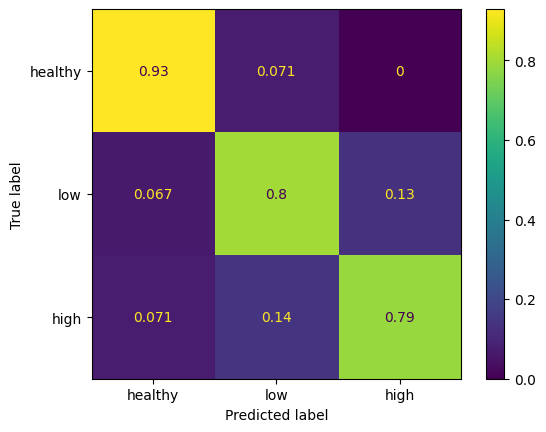

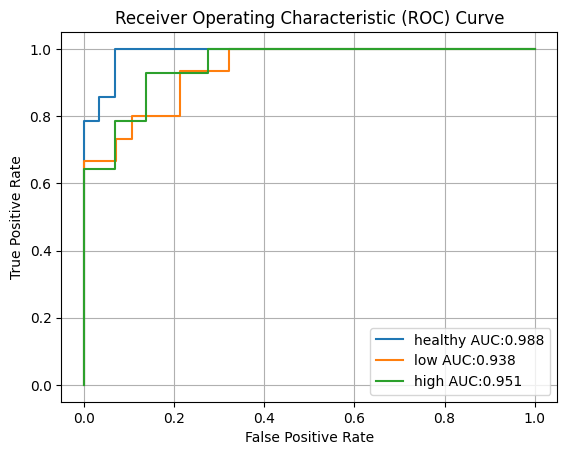

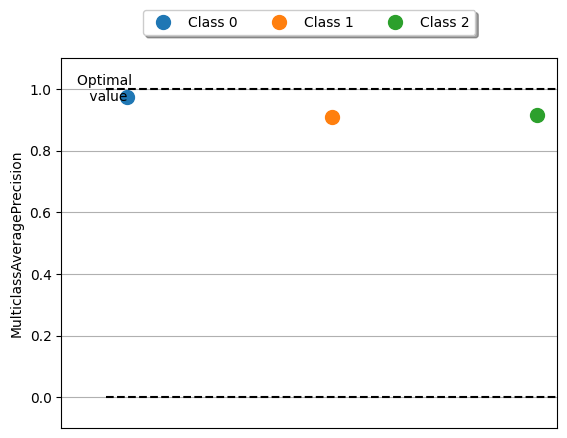

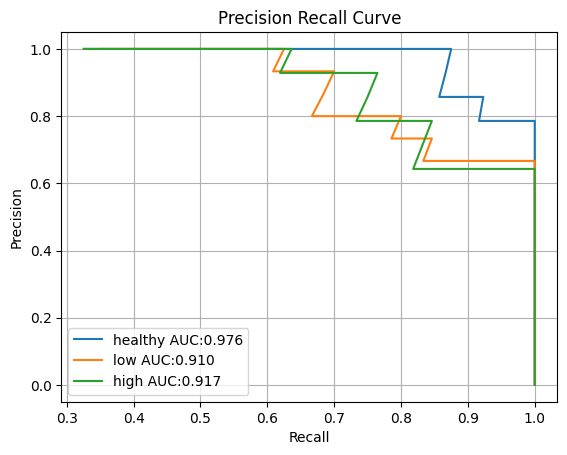

In [73]:
get_metrics(torch.stack(all_lkid['final_pred']),torch.stack(all_lkid['actual']), torch.stack(all_lkid['preds']), 'left_kidney')

In [ ]:
correct_rkid, fail_rkid, all_rkid = infer(right_kidney_model, test_right_kidney_data)

In [ ]:
fail_rkid['series']

In [ ]:
fail_rkid['preds']

In [ ]:
get_metrics(torch.stack(all_rkid['final_pred']),torch.stack(all_rkid['actual']), torch.stack(all_rkid['preds']), 'right_kidney')

In [ ]:
correct_liver, fail_liver, all_liver = infer(liver_model, test_liver_data)

In [ ]:
fail_liver['series']

In [ ]:
fail_liver['preds']

In [ ]:
get_metrics(torch.stack(all_liver['final_pred']),torch.stack(all_liver['actual']), torch.stack(all_liver['preds']), 'liver')

In [ ]:
correct_spleen, fail_spleen, all_spleen = infer(spleen_model, test_spleen_data)

In [ ]:
fail_spleen['series']

In [ ]:
fail_spleen['preds']

In [ ]:
get_metrics(torch.stack(all_spleen['final_pred']),torch.stack(all_spleen['actual']), torch.stack(all_spleen['preds']), 'spleen')

In [ ]:
def get_kidney_pred(all_lkid, all_rkid):
    all_lkid = pd.DataFrame(all_lkid)
    all_rkid = pd.DataFrame(all_rkid)
    merged_df = pd.merge(all_lkid, all_rkid, on='series', how='outer')
    merged_df['conf'] = merged_df[['conf_x', 'conf_y']].max(axis=1)
    merged_df['final_pred'] = merged_df.apply(lambda row: row['final_pred_x'] 
                                              if row['conf_x'] >= row['conf_y'] 
                                              else row['final_pred_y'], axis=1)
    merged_df['preds'] = merged_df.apply(lambda row: row['preds_x'] 
                                              if row['conf_x'] >= row['conf_y'] 
                                              else row['preds_y'], axis=1)
    merged_df['actual'] = merged_df.apply(lambda row: row['actual_x'] 
                                              if row['conf_x'] >= row['conf_y'] 
                                              else row['actual_y'], axis=1)
    
    
    # Identify rows in df1 and df2 that don't have a corresponding row in the other DataFrame
    missing_rows_all_lkid = merged_df[merged_df['series'].isin(all_lkid['series']) & ~merged_df['series'].isin(all_rkid['series'])]
    missing_rows_all_rkid = merged_df[merged_df['series'].isin(all_rkid['series']) & ~merged_df['series'].isin(all_lkid['series'])]
    
#     print('Left kidney but no right kidney:', missing_rows_all_lkid)
#     print('Right kidney but no left kidney:',missing_rows_all_rkid)
    
    # Update the 'conf' column in the merged DataFrame for the missing rows
    merged_df.loc[merged_df['series'].isin(missing_rows_all_lkid['series']), 'conf'] = missing_rows_all_lkid['conf']
    merged_df.loc[merged_df['series'].isin(missing_rows_all_rkid['series']), 'conf'] = missing_rows_all_rkid['conf']
    merged_df.drop(['conf_x', 'conf_y', 
                    'final_pred_x', 'final_pred_y', 
                    'preds_x', 'preds_y',
                    'actual_x', 'actual_y'], axis=1, inplace=True)
    
    # Create a boolean mask indicating the locations of NaN values
    mask = missing_rows_all_lkid.isnull()
    # Use the 'any()' function to check which columns have at least one NaN value
    columns_with_nan = missing_rows_all_lkid.columns[mask.any()].tolist()
    missing_rows_all_lkid.drop(columns_with_nan, axis=1, inplace=True)
    
    # Rename the column using the rename() function
    missing_rows_all_lkid = missing_rows_all_lkid.drop(missing_rows_all_lkid.columns[-1], axis=1)
    missing_rows_all_lkid.rename(columns={'preds_x': 'preds', 'final_pred_x':'final_pred', 'conf_x':'conf', 'actual_x':'actual'}, inplace=True)
    
    # Print the columns with NaN values
#     print(missing_rows_all_lkid)
    merged_df = merged_df[merged_df['series'] != missing_rows_all_lkid['series'].iloc[0]]
    # Append df2 to df1
    merged_df = pd.concat([missing_rows_all_lkid, merged_df], ignore_index=True)
    
    return merged_df

In [ ]:
all_kidney = get_kidney_pred(all_lkid, all_rkid)

In [ ]:
all_kidney

In [ ]:
get_metrics(torch.Tensor(all_kidney['final_pred']),torch.Tensor(all_kidney['actual']), torch.stack(all_kidney['preds']), 'kidney_herehere')

In [ ]:
dummy = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(left_kidney_model, dummy, f'{base_path}/weights/left_kidney/resnet50_left_kidney.onnx', input_names = ['image'])

In [ ]:
dummy = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(right_kidney_model, dummy, f'{base_path}/weights/right_kidney/resnet50_right_kidney.onnx', input_names = ['image'])

In [ ]:
dummy = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(liver_model, dummy, f'{base_path}/weights/liver/resnet50_liver.onnx', input_names = ['image'])

In [ ]:
efficientb2_dummy = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(spleen_model, dummy, f'{base_path}/weights/spleen/resnet50_spleen.onnx', input_names = ['image'])

In [ ]:
import onnxruntime as ort
import os
from PIL import Image
import torch
from torchvision import transforms
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

def preprocess(image):
    process = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
    )

    input_tensor = process(image)
    return input_tensor.unsqueeze(dim=0).numpy()

class Data(Dataset):
    def __init__(self, path, organ):
        self.path = path
        self.organ = organ
        self.series = sorted(os.listdir(path))

        self.df = pd.read_csv(f'{self.path}/{organ}.csv')

        self.series.pop(self.series.index(f'{organ}.csv'))
        
    def __len__(self):
        return len(self.series)
    

    def __getitem__(self, idx):
        chosen_series = self.series[idx]
        label = self.df[self.df['img_path'].str.contains(f'{chosen_series}')]['label'].iloc[0]
        label = int(label)

        image_series = os.listdir(f'{self.path}/{chosen_series}')

        input_tensor = np.array([preprocess(Image.open(f'{self.path}/{chosen_series}/{slice}')) 
                                    for slice in image_series])
        return input_tensor, label, chosen_series
    



lk_model = ort.InferenceSession(f'{base_path}/weights/left_kidney/efficientb2_left_kidney.onnx')
rk_model = ort.InferenceSession(f'{base_path}/weights/right_kidney/efficientb2_right_kidney.onnx')
liver_model = ort.InferenceSession(f'{base_path}/weights/liver/efficientb2_liver.onnx')
spleen_model = ort.InferenceSession(f'{base_path}/weights/spleen/efficientb2_spleen.onnx')


def predict(model, image):
    if len(image) == 1:
        image = image.numpy()
    output = torch.Tensor(model.run(None, {'image':image})[0]).squeeze()
    so = torch.nn.Softmax(dim=0)
    output = so(output)
    return output

# # Assigning weight for weighted vote
# def assign_weight(images, df):
#     weights = []
#     if len(images) % 2 != 0:
#         middle_index = (len(images) - 1) / 2
#     else:
#         middle_index = len(images) / 2
        
#     for i, image in enumerate(images):
#         if abs(i - middle_index) <= len(images) / 4:
#             weights.append(1.0)  # Assign weight 1 if the image is within the middle 50%
#         else:
#             weights.append(0.5)  # Assign weight 0.5 otherwise
#     return np.array(weights)

def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    series = [item[2] for item in batch]
    return [data, target, series]

# Handle input
def infer(model, organ):
    data = Data(f'{base_path}/{organ}', organ)
    loader = DataLoader(data, batch_size=1, num_workers=4)
    df = pd.read_csv(f'{base_path}/{organ}/{organ}.csv')
    correct = 0
    all_list = {'series':[], 'pred_slices':[], 'preds':[], 'final_pred':[],'conf':[] , 'actual':[]}
    fail_list = {'series':[], 'pred_slices':[], 'preds':[], 'final_pred':[],'conf':[] , 'actual':[]}
    for series_batch, label_batch, chosen_series_batch in tqdm(loader):
        for series, label, chosen_series in zip(series_batch, label_batch, chosen_series_batch):
            weights = df[df['img_path'].str.contains(f'{chosen_series}')]['conf']
            preds = []
            for i, image in enumerate(series):
                output = predict(model, image)*weights.iloc[i]
                preds.append(output.numpy())
            
            all_list['pred_slices'].append(np.array(preds))
            class_prob = np.sum(np.array(preds), axis=0)/len(preds)
            all_list['preds'].append(class_prob)
            final_pred = class_prob.argmax()
            confidence = class_prob.max()
            
            all_list['conf'].append(confidence)
            all_list['series'].append(chosen_series)
            all_list['final_pred'].append(final_pred)
            all_list['actual'].append(int(label))

            if final_pred == int(label):
                correct += 1
            else:
                fail_list['series'].append(chosen_series)
                fail_list['pred_slices'].append(np.array(preds))
                fail_list['preds'].append(class_prob)
                fail_list['final_pred'].append(final_pred)
                fail_list['conf'].append(confidence)
                fail_list['actual'].append(int(label))
    correct /= len(data)
    return correct, fail_list, all_list
        

In [ ]:
correct_spleen, fail_spleen, all_spleen = infer(spleen_model, 'spleen')

In [ ]:
correct_spleen, fail_spleen

In [ ]:
get_metrics(torch.Tensor(all_spleen['final_pred']),torch.Tensor(all_spleen['actual']), torch.Tensor(all_spleen['preds']), 'spleen')

In [ ]:
correctl_kid, fail_lkid, all_lkid = infer(lk_model, 'left_kidney')

In [ ]:
healthy_probs = torch.tensor(all_lkid['pred_slices'][0][:, 0])
low_probs = torch.tensor(all_lkid['pred_slices'][0][:, 1])
high_probs = torch.tensor(all_lkid['pred_slices'][0][:, 2])

indexes = all_lkid['pred_slices'][0] > 0.5
indexes = indexes.astype(int)
true_labels_healthy = torch.tensor(indexes[:, 0])  # Binary labels for "healthy" class
true_labels_low = torch.tensor(indexes[:, 1])  # Binary labels for "low" class
true_labels_high = torch.tensor(indexes[:, 2])  # Binary labels for "high" class

# Calculate ROC curve and AUC for the "healthy" class
roc_healthy = torchmetrics.classification.BinaryROC()
roc_healthy.update(healthy_probs, true_labels_healthy)
roc_healthy.plot(score = True)
fpr_healthy, tpr_healthy, _ = roc_healthy.compute()

# Calculate ROC curve and AUC for the "low" class
roc_low = torchmetrics.classification.BinaryROC()
roc_low.update(low_probs, true_labels_low)
roc_low.plot(score = True)
fpr_low, tpr_low, _ = roc_low.compute()

# Calculate ROC curve and AUC for the "high" class
roc_high = torchmetrics.classification.BinaryROC()
roc_high.update(high_probs, true_labels_high)
roc_high.plot(score = True)
fpr_high, tpr_high, _ = roc_high.compute()

# Plot ROC curves
plt.figure()
plt.plot(fpr_healthy, tpr_healthy, label='Healthy')
plt.plot(fpr_low, tpr_low, label='Low')
plt.plot(fpr_high, tpr_high, label='High')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
data = Data(f'{base_path}/spleen', 'spleen')

In [ ]:
get_metrics(torch.Tensor(all_lkid['final_pred']),torch.Tensor(all_lkid['actual']), torch.Tensor(all_lkid['preds']), 'left_kidney')

In [ ]:
true_labels_healthy = torch.zeros()  # Binary labels for "healthy" class
true_labels_low = torch.tensor([0, 1, 0, 1, 0])  # Binary labels for "low" class
true_labels_high = torch.tensor([0, 0, 1, 0, 1])  # Binary labels for "high" class

In [ ]:
correctl_kid, fail_lkid

In [ ]:
correctr_kid, fail_rkid, all_rkid = infer(rk_model, 'right_kidney')

In [ ]:
get_metrics(torch.Tensor(all_rkid['final_pred']),torch.Tensor(all_rkid['actual']), torch.Tensor(all_rkid['preds']), 'right_kidney')

In [ ]:
get_metrics(torch.Tensor(all_liver['final_pred']),torch.Tensor(all_liver['actual']), torch.Tensor(all_liver['preds']), 'liver')

In [ ]:
correct_liver, fail_liver

In [ ]:
all_kidney = get_kidney_pred(all_lkid, all_rkid)

In [ ]:
all_kidney[all_kidney['series'] == '56841_17007']

In [ ]:
get_metrics(torch.Tensor(all_kidney['final_pred']),torch.Tensor(all_kidney['actual']), torch.Tensor(all_kidney['preds']), 'kidney_herehere')

In [ ]:
lk_df = pd.read_csv(f"{base_path}/left_kidney/left_kidney.csv")
rk_df = pd.read_csv(f"{base_path}/right_kidney/right_kidney.csv")